# Underdamped Langevin in numba

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## I/ Implement a code to solve the non transformed underdamped Langevin

The system is of the form: 
$$
\begin{align}
dq&=pdt \\
dp&= F(q) dt - \gamma p dt + \sqrt{2 \frac{\gamma}{\beta}} dW
\end{align}
$$
with $U(x)= \frac{1}{2x^2}+ x^2$ and $F(x) =- \nabla U(x) = -(-\frac{1}{x^3}+ 2x)$.

### A) The role of temperature and friction
To get an intuition on the role of the temperature and friction, one can look at the convergence condition of each steps of the BAOAB method. 


One can look at the stability property of the BAOAB method applied to the SDE ref sde of interest. 
Step A and B do not have any conditions on $\Delta t$: 
Step A : 
$$
q_{n+1}=q_{n}+p_n \Delta t \\
\rightarrow q_{n+1} = q_0 + \Delta t \sum_i^{n} p_i 
$$
Step B : 
$$
p_{n+1}=p_{n}+F(q_n) \Delta t \\
\rightarrow p_{n+1} = p_0 + \Delta t \sum_i^{n} F(q_i) 
$$
where the conditions on $\Delta t$ regarding stability properties is $\Delta t <1$ and $\Delta t>0$. To see that, we look at equation where $F(x) \approx a+bx$, we use taylor expansion to get an approximation of the function $F$ around the roots. One can plug equation ref at $n$ into equation ref at step $n+1$ and once again equation 1 at steps $n-2$:
$$ 
q_{n+1} = q_0 + \Delta t n p_0 + \Delta t^2 b \left(\frac{n(n-1)}{2} \right) + a \Delta t^2 q_0 \left( \frac{n(n+1)}{2} - (n-2) \right) + a\Delta t^3 \sum_{i=1}^n \sum _{j=1}^{i-1} \sum_{k=1}^{j-1} p_k
$$
where we can see that the term $\Delta t$ appears as a power and therefore the stability condition are $\Delta t<1$.

Regarding step 0, we have: 
$$
p_{n+1} = \exp(-\gamma \Delta t) p_n + \sqrt{(1-\exp(-2 \gamma \Delta t)\beta^{-1})} \mathcal{N}(0,1).
$$
We can see that the stability property of the numerical method:   
$$
\mathbb{E} p_{n+1} = \mathbb{E} p_{n} \exp(-\gamma \Delta t) \\
\rightarrow  \mathbb{E} p_{n+1} = \mathbb{E} p_{0} \exp(-\gamma \Delta t n).
$$
For any $\Delta t>0$, $\lim_{n \to \infty}  p_{0} \exp(-\gamma \Delta t n) =0 $. The convergence depends on the size of $\gamma$. If $\gamma$ is higher, the numerical scheme will converge faster. Regarding the variance, we obtain: 
$$
\mathbb{V} [p_{n+1} ]= \mathbb{E} [p_{n+1}^2] - \left( \mathbb{E} [p_{n+1}]\right)^2 \\
\rightarrow  \mathbb{E} [p_{n+1}] = \left(\mathbb{E} [p_{n}^2] - \left( \mathbb{E} [p_{n}]\right)^2\right) \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i) \\
\rightarrow  \mathbb{Var} [p_{n+1}] = \mathbb{Var} [p_{n}] \exp(-2 h \gamma n) + \beta^{-2} (1-\exp(-2 \gamma h)) \sum_{i=0}^{n} \exp(-2h \gamma i)
$$
where we can see that the sheme should converge for any values of $\gamma$ and $\beta$ ultimately. However, when the value of $\gamma$ increases, the scheme requires a smaller time steps to achieve the same speed of convergence, while $\beta$ guides the size of the upper bound and a smaller $\beta$ and higher $\beta^{-2}$ means that you are requires to go further in time to reach the invariant distribution. 

The fluctuation term is also sometimes written as $ \sqrt{2 \frac{\gamma}{\beta}} = \sqrt{2 k_B \gamma T}$ so that $T = \frac{1}{\beta}$.

Therefore, **a higher temperature requires that we go further in time to reach the same invariant distribution** and **a higher value of $\gamma$ requires smaller time steps to achieve the same speed of convergence**.

### B) Numerical implementation



In [2]:
"""
This python file designed a numerical method for SDEs applied to the case of the underdamped langevin dynamic (two dimensional SDE). 
The underdamped system has a potential that is in q^2. 
Because it is two-dimensional, it is necessary to apply an other method than just Euler-Maruyama, so we use the BAOAB method. 
The numerical methods is applied to the transformed SDE using the adaptive function g(x)
The adaptive function is the exponential bounded between dtbounds[0] and dtbounds[1]

This file includes: 
- plot_qp(qp,beta,gamma): a function to plot the true distribution alongside the histogram of the generated sample of p and q 
- F(x): a function of the potential 
- nablaU(x): a function of the potential derivative
- g(x): the adaptive function used here
- A(qp,h): step A of the method
- B(qp,h): step B
- O(qp,h,gamma,beta): step O
- one_traj(qp,T,h,gamma,beta): compute all the steps for the required number of increment to reach T
- method_baoab(n_samples,T,gamma,beta,h): compute the BAOAB method for n_samples 
- one_trajN(qp,gamma,beta,h,Ntimes): compute all the steps for a number Ntimes of increment
- method_baoabN(n_samples,gamma,beta,T,Ntimes): compute the BAOAB method for n_samples for N_times 
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb


def F(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def nablaU(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64[:](float64[:],float64))
def A(qp,h):
    q=qp[0]
    p=qp[1]
    q = q+p*h
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64))
def B(qp,h):
    q=qp[0]
    p=qp[1]
    p = p-nablaU(q)*h
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64,float64,float64))
def O(qp,h,gamma,beta):
    q=qp[0]
    p=qp[1]
    dB = np.random.normal(0,1)
    alpha =np.exp(-gamma*h)
    p = alpha*p+ np.sqrt((1-alpha*alpha)/beta)*dB
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64,float64,float64,float64))
def one_traj(qp,T,h,gamma,beta):
    h_half=h/2
    for i in range(int(T/h)):
        qp=B(qp,h_half)
        qp=A(qp,h_half)
        qp=O(qp,h_half,gamma,beta)
        qp=A(qp,h_half)
        qp=B(qp,h_half)
    return (qp)

@njit(parallel=True)
def method_baoab(N,T,gamma,beta,h):
    qp_list=np.zeros((N,2))
    qipi = np.array([1.0,1.0]) #np.random.normal(0,1,2) #initial conditions
    for j in nb.prange(N):
        qfpf = one_traj(qipi,T,h,gamma,beta)
        qp_list[j,::]=qfpf
    return(qp_list)

@njit(float64[:](float64[:],float64,float64,float64,float64))
def one_trajN(qp,gamma,beta,h,Ntimes):
    h_half=h/2
    for i in range(Ntimes):
        qp=B(qp,h_half)
        qp=A(qp,h_half)
        qp=O(qp,h_half,gamma,beta)
        qp=A(qp,h_half)
        qp=B(qp,h_half)
    return (qp)

@njit(parallel=True)
def method_baoabN(n_samples,gamma,beta,T,Ntimes):
    qp_list=np.zeros((n_samples,2))
    qipi = np.array([1.0,1.0]) #np.random.normal(0,1,2) #initial conditions
    h=np.round(T/Ntimes,6)
    for j in nb.prange(n_samples):
        qfpf = one_trajN(qipi,gamma,beta,h,Ntimes)
        qp_list[j,::]=qfpf
    return(qp_list)

    
# axis of the plot 
def plot_qp(qp,beta,gamma):
    fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(16,6))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    fig.suptitle("$\\beta$="+str(beta)+", $\\gamma=$"+str(gamma)+", $N=$"+str(len(qp[::,0])))

    #Plot 1
    ## position q experiment
    histogram,bins = np.histogram(qp[::,0],bins=100,range=[0,3], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='q-Experiment')
    ax1.legend() 

    #Plot 2: 
    ### momentum p experiment
    histogram,bins = np.histogram(qp[::,1],bins=100,range=[-3,3], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    # histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
    ax2.plot(midx_p,histogram,label='p-Experiment')

    ### position q true
    rho = np.exp(- beta*U(midx_q))
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    ax1.plot(midx_q,rho,'--',label='Truth')
    ax1.legend() 

    ### momentum p true
    rho = np.exp(- beta*(midx_p**2)/2)
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    ax2.plot(midx_p,rho,'--',label='Truth')
    ax2.legend() 

    #Plot 3 
    ax3.set_ylim(-5,5)
    ax3.plot(qp[::,1],label="p")
    ax3.plot(qp[::,0],label="q")

    ax3.legend()


### C) Results


In [12]:
## Compile the code
T=10
h = 0.1
gamma = 1
beta=1
# compile
Ntimes=100
n_samples=100
%time method_baoabN(n_samples,gamma,beta,T,Ntimes)
%time qp_list=method_baoabN(n_samples,gamma,beta,T,Ntimes)


CPU times: user 467 ms, sys: 3.97 ms, total: 471 ms
Wall time: 48.4 ms
CPU times: user 274 ms, sys: 0 ns, total: 274 ms
Wall time: 29.4 ms


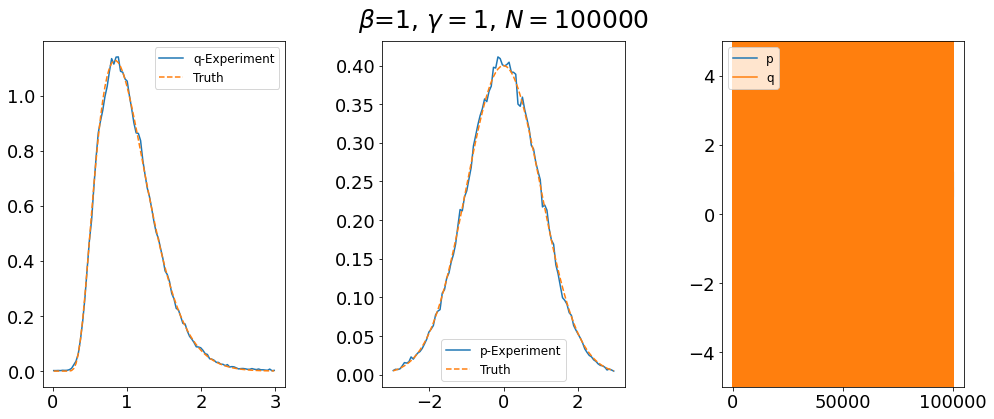

In [13]:
### Standard results 
T=100
h = 0.1
gamma = 1
beta=1
n_samples=10**5
Ntimes=int(T*1/h)
qp4=method_baoabN(n_samples,gamma,beta,T,Ntimes)
plot_qp(qp4,beta,gamma)

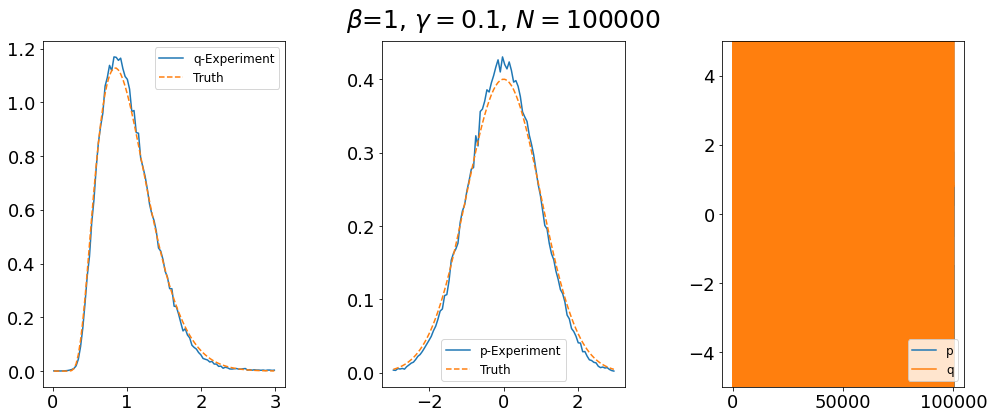

In [14]:
### Low friction: lower convergence
T=100
h = 0.1
gamma = 0.1
beta=1
n_samples=10**5
Ntimes=int(T*1/h)
qp4=method_baoabN(n_samples,gamma,beta,T,Ntimes)
plot_qp(qp4,beta,gamma)

In [15]:
### Small beta or high temperature, upper bound on convergence is larger 
T=100
h = 0.1
gamma = 1
beta=0.1
n_samples=10**5
Ntimes=int(T*1/h)
qp4=method_baoabN(n_samples,gamma,beta,T,Ntimes)
plot_qp(qp4,beta,gamma)

## II/ Implement a code to solve the transformed underdamped Langevin


### A) Numerical implemetation
The system is of the form: 
$$
\begin{align}
dq&=pdt \\
dp&= F(q) dt - \gamma p dt + \sqrt{2 \frac{\gamma}{\beta}} dW
\end{align}
$$
with $F(q)= q^2/2$.

We have using $\frac{dt}{ds} = g(x)$ that the system below has the same invariant distribution: 
$$
\begin{align}
dq&=g(q)pdt \\
dp&= g(q) F(q) dt + \beta^{-1} g'(q) dt- \gamma g(q) p dt + \sqrt{2 \frac{\gamma}{\beta} g(q)} dW
\end{align}
$$
with $F(q)= q^2/2$.

With the method BAOAB, we include the computation of the extra term $\beta^{-1} g'(q)$ in step B: 
1. Step A
$$
dq=pdt\\
\dot{p}=0
$$
can not be simply generated as: 
$$
q_{n+1}=q_n+h p_n g(q_n)
$$
due to the non linearity of the term $g(q_n)$. 
Let's try and get a better method by using: 
$$
q_{n+1}=q_n+h p_n g(\frac{q_n+q_{n+1}}{2})
$$
where $q_{n+1/2} = \frac{q_n+q_{n+1}}{2}$.

We have:  
$$
q_{n+1/2} = q_n + \frac{h}{2} p g(q_{n+1/2}) \\
g(q_{n+1/2}) = g( q_n + \frac{h}{2} p g(q_{n+1/2})) \\
g_{n+1/2} = g( q_n + \frac{h}{2} p g_{n+1/2}) \\
$$
and now we can use fixed point iterations by setting : 
$$

\mathbf{g^0_{n+1/2} = g( q_n + \frac{h}{2} p g_{n})} \\
\mathbf{g^1_{n+1/2} = g( q_n + \frac{h}{2} p g^0_{n+1/2})} \\
\mathbf{g^2_{n+1/2} = g( q_n + \frac{h}{2} p g^1_{n+1/2})} \\
\mathbf{g^3_{n+1/2} = g( q_n + \frac{h}{2} p g^2_{n+1/2}) \\
\dots}
$$

and finally compute: 
$$
\mathbf{q_{n+1}=q_n+h p_n g^l_{n+1/2}}
$$


2. Step B . 
$$
dp=g(q) F(q) ds\\
\dot{q}=0
$$
is generated as: 

$$
\mathbf{p_{n+1}=p_n-h \left(g(q_n)F(q_n)+\beta^{-1} g'(q_n) \right)}
$$

3. Step O
$$
dp=-g(q) \gamma p ds + \sqrt{2 \gamma \beta^-1 g(q)} dW(s)\\
\dot{q}=0
$$
is generated as: 
$$
\mathbf{p_{n+1}=\exp(-\gamma g(q_n) h) p_n+ \sqrt{\frac{1-\exp(2 \gamma g(q_n)h)}{\beta}} \mathcal{N}(0,1)}
$$

In [8]:

"""
This python file designed a numerical method for SDEs applied to the case of the underdamped langevin dynamic 
(two dimensional SDE). 
We use the BAOAB method. 
The numerical methods is applied to the transformed SDE using the adaptive function g(x)

This file includes: 
- plot_distr(y,tau,dt,n_samples,T,title,ax): a function to plot the true distribution alongside the histogram of the generated sample 
- F(x): a function of the potential 
- nablaU(x): a function of the potential derivative
- g(x): the adaptive function used here
- A_ada(qp,h): step A of the method
- B_ada(qp,h): step B
- O_ada(qp,h,gamma,beta): step O
- one_traj_ada(qp,T,h,gamma,beta): compute all the steps for the required number of increment to reach T
- method_baoab_ada(n_samples,T,gamma,beta,h): compute the BAOAB method for n_samples 
"""


import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time

def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def nablaU(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    # dtmin=0.005
    # dtmax=0.01
    # R=1
    # y=(dtmax-dtmin)/dtmax*(1-np.exp(-np.abs(x)*R))+dtmin/dtmax
    g=1
    return g

@njit(float64(float64))
def getgprime(x): #,dtmin, dtmax, R):
    # dtmin=0.005
    # dtmax=0.01
    # R=1
    # y=(dtmax-dtmin)/dtmax*(1-np.exp(-np.abs(x)*R))+dtmin/dtmax
    gprime=0
    return gprime

@njit(float64[:](float64[:],float64))
def A_ada(qp,h):
    q=qp[0]
    p=qp[1]
    gq = qp[2]
    ## fixed point method for g((qn+1+qn)/2)
    g_half = getg(q+0.5*h*p*gq)
    g_half = getg(q+0.5*h*p*g_half)
    g_half = getg(q+0.5*h*p*g_half)
    g_half = getg(q+0.5*h*p*g_half)
    gq = g_half
    q = q+p*gq*h
    qp=np.array([q,p])
    return (qp)

@njit(float64[:](float64[:],float64,float64))
def B_ada(qp,h,beta):
    q=qp[0]
    p=qp[1]
    gq=getg(q)
    gprime=getgprime(q)
    p = p-gq*nablaU(q)*h + h/beta*gprime
    qp_gq=np.array([q,p,gq])
    return (qp_gq)

@njit(float64[:](float64[:],float64,float64,float64))
def O_ada(qp,h,gamma,beta):
    q=qp[0]
    p=qp[1]
    dB = np.random.normal(0,1,1)[0]
    gq=getg(q)
    alpha =np.exp(-gamma*h*gq)
    p = alpha*p+ np.sqrt((1-alpha*alpha)/beta)*dB
    qp_gq=np.array([q,p,gq])
    return (qp_gq)

@njit(float64[:](float64[:],float64,float64,float64,float64))
def one_traj_ada(qp,T,h,gamma,beta):
    t=0
    h_half=h/2
    while t<T:
        qp_gq=B_ada(qp,h_half,beta)
        qp=A_ada(qp_gq,h_half)
        qp_gq=O_ada(qp,h_half,gamma,beta)
        qp=A_ada(qp_gq,h_half)
        qp_gq=B_ada(qp,h_half,beta)
        qp=qp_gq[:2]
        gq=qp_gq[2]
        t=np.round(t+gq*h,7)
    return (qp)

@njit(parallel=True)
def method_baoab_ada(n_samples,gamma,beta,T,h):
    qp_list=np.zeros((n_samples,2))
    qipi = np.array([1.0,1.0]) #np.random.normal(0,1,2) #initial conditions
    for j in nb.prange(n_samples):
        qfpf = one_traj_ada(qipi,T,h,gamma,beta)
        qp_list[j,::]=qfpf
    return(qp_list)

#compile the method
qp = method_baoab_ada(1,1,0.1,0.5,0.01)



In [5]:
# compile code
T=10
h = 0.1
gamma = 1
beta=1
# compile
Ntimes=100
n_samples=100
%time method_baoab_ada(1,gamma,beta,2,1)


CPU times: user 1.25 s, sys: 624 µs, total: 1.26 s
Wall time: 1.25 s


array([[0.40654483, 7.2883607 ]])

In [10]:
T=100
h = 0.1
gamma = 1
beta=1
n_samples=10**5
Ntimes=int(T*1/h)
qp_ada = method_baoab_ada(n_samples,gamma,beta,T,h)

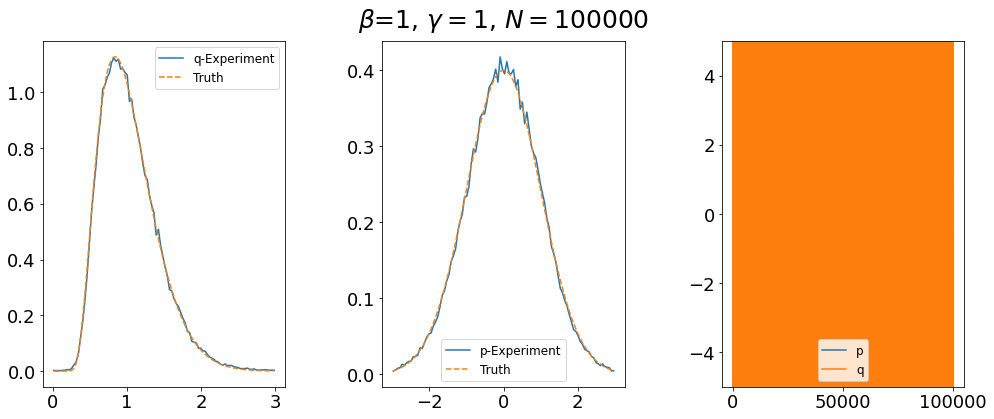

In [11]:
plot_qp(qp_ada,beta,gamma)